In [62]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[1] "house-data-app-test-outlier-encoded-one"

In [63]:
library(ggplot2)
library(moments)
library(gridExtra)
library(Metrics)
library(caret)

In [64]:
R.squared <- function(Y, Ypred){
    SCR.p = sum((Y - Ypred)^2)
    SCR.o = sum((Y - mean(Ypred))^2) 
    rsquared = 1 - (SCR.p / SCR.o)
    rsquared
}

In [65]:
R.squared.adj <- function(Y, Ypred, n, p){
    SCR.p = sum((Y - Ypred)^2)
    SCR.o = sum((Y - mean(Ypred))^2) 
    rsquared = 1 - (SCR.p / SCR.o)
    rsquared.adj = 1 - ((n-1)/(n-p-1)) * (1-rsquared)
    rsquared.adj
}

In [66]:
Perfopm10 = function(obs,prev) {
    Len_obs = length(obs)
    R    = cor(obs , prev)
    RMSE = sqrt(sum((obs - prev)^2)/length(obs))
    RMSLE = sqrt(sum((log(obs) - log(prev))^2)/length(obs))
    
    cat(' \n')
    cat("********************** \n")
    cat(" Erreurs  en prevision  \n")
    cat("********************** \n")
    cat(' \n ')
    cat('R²      = ', round(R,4),' \n ')
    cat('RMSE   = ', round(RMSE,4),' \n ')
    cat('RMSLE   = ', round(RMSLE,4),' \n ')
    cat(' \n')
}

### Données d'apprentissage et de test

In [67]:
dataAppLog   <- read.csv("../input/house-data-app-test-outlier-encoded-one/dataOutlierApp_Chris.csv", 
                         stringsAsFactors = F)
dataTestLog  <-   read.csv("../input/house-data-app-test-outlier-encoded-one/dataOutlierTest_Chris.csv",
                           stringsAsFactors = F)

### Régression linéaire

In [68]:
reslmLog <- lm(SalePrice~.,data=dataAppLog)

In [69]:
summary(reslmLog)


Call:
lm(formula = SalePrice ~ ., data = dataAppLog)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.62514 -0.05288  0.00000  0.05703  0.51625 

Coefficients: (20 not defined because of singularities)
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  1.609e+01  5.345e+00   3.010 0.002686 ** 
MSSubClass                  -7.248e-03  1.277e-02  -0.568 0.570423    
LotFrontage                  3.323e-04  2.265e-04   1.467 0.142686    
LotArea                      1.326e-06  4.913e-07   2.698 0.007111 ** 
Street                       3.593e-02  5.240e-02   0.686 0.493046    
Alley                       -1.374e-02  1.720e-02  -0.799 0.424600    
Utilities                           NA         NA      NA       NA    
Condition1                   5.138e-02  1.246e-02   4.124 4.07e-05 ***
Condition2                   1.548e-03  3.905e-02   0.040 0.968389    
HouseStyle                  -1.966e-02  1.326e-02  -1.483 0.138541    
Over

In [70]:
summary(reslmLog)$r.squared
summary(reslmLog)$adj.r.squared

[1] 0.9401831

[1] 0.9321986

In [71]:
# Make predictions
predictionsApp <- reslmLog %>% predict(dataAppLog)
predictLmApp <- exp(predictionsApp)

data.frame(
  Rsquared = R.squared(predictLmApp, exp(dataAppLog$SalePrice)),
  Rsquared.adj = R.squared.adj(predictLmApp, exp(dataAppLog$SalePrice),
                             nrow(dataAppLog), ncol(dataAppLog[, -1])),
  RMSE = RMSE(predictLmApp, exp(dataAppLog$SalePrice)),
  RMSLE = rmsle(predictLmApp, exp(dataAppLog$SalePrice))
)

Warning message in predict.lm(., dataAppLog):
“prediction from a rank-deficient fit may be misleading”


Rsquared,Rsquared.adj,RMSE,RMSLE
<dbl>,<dbl>,<dbl>,<dbl>
0.948961,0.940832,17131.51,0.09631442


In [72]:
Perfopm10(exp(dataAppLog$SalePrice), predictLmApp)

 
********************** 
 Erreurs  en prevision  
********************** 
 
 R²      =  0.9753  
 RMSE   =  17131.51  
 RMSLE   =  0.0963  
  


In [73]:
### Make predictions
predictions <- reslmLog %>% predict(dataTestLog)
predictLm <- exp(predictions)

data.frame(
  Rsquared = R.squared(predictLm, exp(dataTestLog$SalePrice)),
  Rsquared.adj = R.squared.adj(predictLm, exp(dataTestLog$SalePrice),
                             nrow(dataTestLog), ncol(dataTestLog[, -1])),
  RMSE = RMSE(predictLm, exp(dataTestLog$SalePrice)),
  RMSLE = rmsle(predictLm, exp(dataTestLog$SalePrice))
)

Warning message in predict.lm(., dataTestLog):
“prediction from a rank-deficient fit may be misleading”


Rsquared,Rsquared.adj,RMSE,RMSLE
<dbl>,<dbl>,<dbl>,<dbl>
0.9129168,0.8718675,23106.41,0.1220586


In [74]:
Perfopm10(exp(dataTestLog$SalePrice), predictLm)

 
********************** 
 Erreurs  en prevision  
********************** 
 
 R²      =  0.9615  
 RMSE   =  23106.41  
 RMSLE   =  0.1221  
  


In [75]:
library(mgcv)

## GAM

In [76]:
## Mettre SalePrice comme dernière colonne
dataAppLogGam <- select(dataAppLog, -SalePrice, everything())
dataTestLogGam <- select(dataTestLog, -SalePrice, everything())

### Variables quantitatives

In [77]:
### Liste des variables quantitatives utilisées pour les GAM non linéaires
### Mettre vos variables quantitatives (pour Farida c'est pareil)
colQuant <- c('LotFrontage', 'LotArea', 'MasVnrArea','BsmtFinSF1','BsmtFinSF2',
             'BsmtUnfSF', 'X1stFlrSF','X2ndFlrSF','LowQualFinSF', 'TotalSqFeet', 
             'GarageCars','GarageArea','WoodDeckSF', 'TotalPorchSF','PoolArea')

#### Variables quantitatives retirées à cause du nombre de noeuds
'TotalBsmtSF','BsmtFullBath','BsmtHalfBath', 'FullBath','HalfBath', 'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',

In [78]:
colQuant

[1] "LotFrontage"  "LotArea"      "MasVnrArea"   "BsmtFinSF1"   "BsmtFinSF2"  
 [6] "BsmtUnfSF"    "X1stFlrSF"    "X2ndFlrSF"    "LowQualFinSF" "TotalSqFeet" 
[11] "GarageCars"   "GarageArea"   "WoodDeckSF"   "TotalPorchSF" "PoolArea"

### Variables qualitatives

In [79]:
### Reste des variables sans SalePrice
colQual <- names(dataAppLogGam[, !names(dataAppLogGam) %in% colQuant])
colQual <- colQual[-length(colQual)]
colQual

[1] "MSSubClass"                  "Street"                     
  [3] "Alley"                       "Utilities"                  
  [5] "Condition1"                  "Condition2"                 
  [7] "HouseStyle"                  "OverallQual"                
  [9] "OverallCond"                 "RoofStyle"                  
 [11] "RoofMatl"                    "Exterior1st"                
 [13] "Exterior2nd"                 "AgeBuilt"                   
 [15] "AgeRemodAdd"                 "ExterQual"                  
 [17] "ExterCond"                   "BsmtQual"                   
 [19] "BsmtCond"                    "BsmtExposure"               
 [21] "BsmtFinType1"                "BsmtFinType2"               
 [23] "Heating"                     "HeatingQC"                  
 [25] "CentralAir"                  "BsmtFullBath"               
 [27] "BsmtHalfBath"                "FullBath"                   
 [29] "HalfBath"                    "BedroomAbvGr"               
 [31] "KitchenAbvGr"                "KitchenQual"                
 [33] "TotRmsAbvGrd"                "Fireplaces"                 
 [35] "FireplaceQu"                 "GarageAge"                  
 [37] "GarageFinish"                "GarageQual"                 
 [39] "GarageCond"                  "MiscFeaturePres"            
 [41] "MoSold"                      "YrSold"                     
 [43] "MSZoning.C..all."            "MSZoning.FV"                
 [45] "MSZoning.RH"                 "MSZoning.RL"                
 [47] "MSZoning.RM"                 "LotShape.IR1"               
 [49] "LotShape.IR2"                "LotShape.IR3"               
 [51] "LotShape.Reg"                "LandContour.Bnk"            
 [53] "LandContour.HLS"             "LandContour.Low"            
 [55] "LandContour.Lvl"             "LotConfig.Corner"           
 [57] "LotConfig.CulDSac"           "LotConfig.FR2"              
 [59] "LotConfig.FR3"               "LotConfig.Inside"           
 [61] "LandSlope.Gtl"               "LandSlope.Mod"              
 [63] "LandSlope.Sev"               "Neighborhood.BlmCCC"        
 [65] "Neighborhood.BlMiNAmNpkSaSW" "Neighborhood.GNwSaW"        
 [67] "Neighborhood.NoNri"          "Neighborhood.STV"           
 [69] "BldgType.1Fam"               "BldgType.2fmCon"            
 [71] "BldgType.Duplex"             "BldgType.Twnhs"             
 [73] "BldgType.TwnhsE"             "MasVnrType.BrkFace"         
 [75] "MasVnrType.Others"           "MasVnrType.Stone"           
 [77] "Foundation.BrkTil"           "Foundation.CBlock"          
 [79] "Foundation.PConc"            "Foundation.Slab"            
 [81] "Foundation.Stone"            "Foundation.Wood"            
 [83] "Electrical.FuseA"            "Electrical.FuseF"           
 [85] "Electrical.FuseP"            "Electrical.Mix"             
 [87] "Electrical.SBrkr"            "Functional.Maj1"            
 [89] "Functional.Maj2"             "Functional.Min1"            
 [91] "Functional.Min2"             "Functional.Mod"             
 [93] "Functional.Sev"              "Functional.Typ"             
 [95] "GarageType.2Types"           "GarageType.Attchd"          
 [97] "GarageType.Basment"          "GarageType.BuiltIn"         
 [99] "GarageType.CarPort"          "GarageType.Detchd"          
[101] "GarageType.None"             "PavedDrive.N"               
[103] "PavedDrive.P"                "PavedDrive.Y"               
[105] "Fence.GdPrv"                 "Fence.GdWo"                 
[107] "Fence.MnPrv"                 "Fence.MnWw"                 
[109] "Fence.None"                  "SaleType.COD"               
[111] "SaleType.Con"                "SaleType.ConLD"             
[113] "SaleType.ConLI"              "SaleType.ConLw"             
[115] "SaleType.CWD"                "SaleType.New"               
[117] "SaleType.Oth"                "SaleType.WD"                
[119] "SaleCondition.Abnorml"       "SaleCondition.AdjLand"      
[121] "SaleCondition.Alloca"        "SaleC

### GAM Linéaire

In [80]:
colQuantQual <- names(dataAppLogGam)
colQuantQual <- colQuantQual[-length(colQuantQual)]

In [81]:
fmQuantQual <- paste(colQuantQual, sep = "", collapse = ' + ')
fmLCheck <- as.formula(paste('SalePrice ~', fmQuantQual))
#fmLCheck

In [82]:
modelGamLCheck <- gam(fmLCheck, data = dataAppLogGam)
summary(modelGamLCheck)


Family: gaussian 
Link function: identity 

Formula:
SalePrice ~ MSSubClass + LotFrontage + LotArea + Street + Alley + 
    Utilities + Condition1 + Condition2 + HouseStyle + OverallQual + 
    OverallCond + RoofStyle + RoofMatl + Exterior1st + Exterior2nd + 
    MasVnrArea + AgeBuilt + AgeRemodAdd + ExterQual + ExterCond + 
    BsmtQual + BsmtCond + BsmtExposure + BsmtFinType1 + BsmtFinSF1 + 
    BsmtFinType2 + BsmtFinSF2 + BsmtUnfSF + Heating + HeatingQC + 
    CentralAir + X1stFlrSF + X2ndFlrSF + LowQualFinSF + BsmtFullBath + 
    BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + 
    KitchenQual + TotRmsAbvGrd + Fireplaces + FireplaceQu + GarageAge + 
    GarageFinish + GarageCars + GarageArea + GarageQual + GarageCond + 
    WoodDeckSF + MiscFeaturePres + MoSold + YrSold + MSZoning.C..all. + 
    MSZoning.FV + MSZoning.RH + MSZoning.RL + MSZoning.RM + LotShape.IR1 + 
    LotShape.IR2 + LotShape.IR3 + LotShape.Reg + LandContour.Bnk + 
    LandContour.HLS + LandCon

In [83]:
# Make predictions
predictionsApp <- modelGamLCheck %>% predict(dataAppLogGam)
predictGamApp <- exp(predictionsApp)

data.frame(
  Rsquared = R.squared(predictGamApp, exp(dataAppLogGam$SalePrice)),
    
  Rsquared.adj = R.squared.adj(predictGamApp, exp(dataAppLogGam$SalePrice),
                             nrow(dataAppLogGam), ncol(dataAppLogGam[, -1])),
    
  RMSE = RMSE(predictGamApp, exp(dataAppLogGam$SalePrice)),
  RMSLE = rmsle(predictGamApp, exp(dataAppLogGam$SalePrice))
)

Rsquared,Rsquared.adj,RMSE,RMSLE
<dbl>,<dbl>,<dbl>,<dbl>
0.948961,0.940832,17131.51,0.09631442


In [84]:
Perfopm10(exp(dataAppLog$SalePrice), predictGamApp)

 
********************** 
 Erreurs  en prevision  
********************** 
 
 R²      =  0.9753  
 RMSE   =  17131.51  
 RMSLE   =  0.0963  
  


In [85]:
# Make predictions
predictionsTest <- modelGamLCheck %>% predict(dataTestLogGam)
predictGamTest <- exp(predictionsTest)

data.frame(
  Rsquared = R.squared(predictGamTest, exp(dataTestLogGam$SalePrice)),
    
  Rsquared.adj = R.squared.adj(predictGamTest, exp(dataTestLogGam$SalePrice),
                             nrow(dataTestLogGam), ncol(dataTestLogGam[, -1])),
    
  RMSE = RMSE(predictGamTest, exp(dataTestLogGam$SalePrice)),
  RMSLE = rmsle(predictGamTest, exp(dataTestLogGam$SalePrice))
)

Rsquared,Rsquared.adj,RMSE,RMSLE
<dbl>,<dbl>,<dbl>,<dbl>
0.9097973,0.8672775,23666.22,0.1787286


In [86]:
Perfopm10(exp(dataTestLog$SalePrice), predictGamTest)

 
********************** 
 Erreurs  en prevision  
********************** 
 
 R²      =  0.9594  
 RMSE   =  23666.22  
 RMSLE   =  0.1787  
  


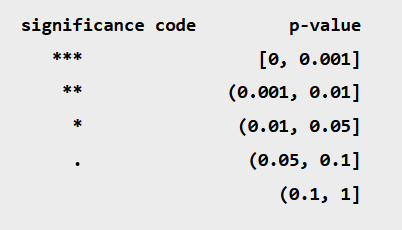

https://www.statology.org/significance-codes-in-r/

https://boostedml.com/2019/06/linear-regression-in-r-interpreting-summarylm.html

### GAM avec des composantes non linéaires

In [87]:
#fmQuant <- paste(colQuant, sep = "", collapse = ' + ')
fmQuantNL <- paste('s(', colQuant, ', k=5, bs="cr")', sep = "", collapse = ' + ')
#fmNL <- paste(fmQuant,'+',fmQuantNL)
fmNL <- as.formula(paste('SalePrice ~', fmQuantNL))
fmNL

SalePrice ~ s(LotFrontage, k = 5, bs = "cr") + s(LotArea, k = 5, 
    bs = "cr") + s(MasVnrArea, k = 5, bs = "cr") + s(BsmtFinSF1, 
    k = 5, bs = "cr") + s(BsmtFinSF2, k = 5, bs = "cr") + s(BsmtUnfSF, 
    k = 5, bs = "cr") + s(X1stFlrSF, k = 5, bs = "cr") + s(X2ndFlrSF, 
    k = 5, bs = "cr") + s(LowQualFinSF, k = 5, bs = "cr") + s(TotalSqFeet, 
    k = 5, bs = "cr") + s(GarageCars, k = 5, bs = "cr") + s(GarageArea, 
    k = 5, bs = "cr") + s(WoodDeckSF, k = 5, bs = "cr") + s(TotalPorchSF, 
    k = 5, bs = "cr") + s(PoolArea, k = 5, bs = "cr")

In [88]:
modelGamNL <- gam(fmNL, data = dataAppLogGam)
summary(modelGamNL)


Family: gaussian 
Link function: identity 

Formula:
SalePrice ~ s(LotFrontage, k = 5, bs = "cr") + s(LotArea, k = 5, 
    bs = "cr") + s(MasVnrArea, k = 5, bs = "cr") + s(BsmtFinSF1, 
    k = 5, bs = "cr") + s(BsmtFinSF2, k = 5, bs = "cr") + s(BsmtUnfSF, 
    k = 5, bs = "cr") + s(X1stFlrSF, k = 5, bs = "cr") + s(X2ndFlrSF, 
    k = 5, bs = "cr") + s(LowQualFinSF, k = 5, bs = "cr") + s(TotalSqFeet, 
    k = 5, bs = "cr") + s(GarageCars, k = 5, bs = "cr") + s(GarageArea, 
    k = 5, bs = "cr") + s(WoodDeckSF, k = 5, bs = "cr") + s(TotalPorchSF, 
    k = 5, bs = "cr") + s(PoolArea, k = 5, bs = "cr")

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.024962   0.005487    2191   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                   edf Ref.df      F  p-value    
s(LotFrontage)  1.9880 2.4801  1.706  0.24156    
s(LotArea)      1.0000 1.0000  7.532  0.00617 ** 

In [89]:
fmQuant <- paste(colQuant, sep = "", collapse = ' + ')
fmQuantNL <- paste('s(', colQuant, ', k=5, bs="cr")', sep = "", collapse = ' + ')
fmNL1 <- paste(fmQuant,'+',fmQuantNL)
fmNL1 <- as.formula(paste('SalePrice ~', fmNL1))
fmNL1

SalePrice ~ LotFrontage + LotArea + MasVnrArea + BsmtFinSF1 + 
    BsmtFinSF2 + BsmtUnfSF + X1stFlrSF + X2ndFlrSF + LowQualFinSF + 
    TotalSqFeet + GarageCars + GarageArea + WoodDeckSF + TotalPorchSF + 
    PoolArea + s(LotFrontage, k = 5, bs = "cr") + s(LotArea, 
    k = 5, bs = "cr") + s(MasVnrArea, k = 5, bs = "cr") + s(BsmtFinSF1, 
    k = 5, bs = "cr") + s(BsmtFinSF2, k = 5, bs = "cr") + s(BsmtUnfSF, 
    k = 5, bs = "cr") + s(X1stFlrSF, k = 5, bs = "cr") + s(X2ndFlrSF, 
    k = 5, bs = "cr") + s(LowQualFinSF, k = 5, bs = "cr") + s(TotalSqFeet, 
    k = 5, bs = "cr") + s(GarageCars, k = 5, bs = "cr") + s(GarageArea, 
    k = 5, bs = "cr") + s(WoodDeckSF, k = 5, bs = "cr") + s(TotalPorchSF, 
    k = 5, bs = "cr") + s(PoolArea, k = 5, bs = "cr")

In [90]:
modelGamNL1 <- gam(fmNL1, data = dataAppLogGam)
summary(modelGamNL1)


Family: gaussian 
Link function: identity 

Formula:
SalePrice ~ LotFrontage + LotArea + MasVnrArea + BsmtFinSF1 + 
    BsmtFinSF2 + BsmtUnfSF + X1stFlrSF + X2ndFlrSF + LowQualFinSF + 
    TotalSqFeet + GarageCars + GarageArea + WoodDeckSF + TotalPorchSF + 
    PoolArea + s(LotFrontage, k = 5, bs = "cr") + s(LotArea, 
    k = 5, bs = "cr") + s(MasVnrArea, k = 5, bs = "cr") + s(BsmtFinSF1, 
    k = 5, bs = "cr") + s(BsmtFinSF2, k = 5, bs = "cr") + s(BsmtUnfSF, 
    k = 5, bs = "cr") + s(X1stFlrSF, k = 5, bs = "cr") + s(X2ndFlrSF, 
    k = 5, bs = "cr") + s(LowQualFinSF, k = 5, bs = "cr") + s(TotalSqFeet, 
    k = 5, bs = "cr") + s(GarageCars, k = 5, bs = "cr") + s(GarageArea, 
    k = 5, bs = "cr") + s(WoodDeckSF, k = 5, bs = "cr") + s(TotalPorchSF, 
    k = 5, bs = "cr") + s(PoolArea, k = 5, bs = "cr")

Parametric coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.846e+00  4.105e-02 118.062  < 2e-16 ***
LotFrontage   6.405e-03  5.216e-04  12.279  < 2

### GAM Linéaire quantitatives

In [91]:
fmQuant <- paste(colQuant, sep = "", collapse = ' + ')
fmL <- as.formula(paste('SalePrice ~', fmQuant))
fmL

SalePrice ~ LotFrontage + LotArea + MasVnrArea + BsmtFinSF1 + 
    BsmtFinSF2 + BsmtUnfSF + X1stFlrSF + X2ndFlrSF + LowQualFinSF + 
    TotalSqFeet + GarageCars + GarageArea + WoodDeckSF + TotalPorchSF + 
    PoolArea

In [92]:
modelGamL <- gam(fmL, data = dataAppLogGam)
summary(modelGamL)


Family: gaussian 
Link function: identity 

Formula:
SalePrice ~ LotFrontage + LotArea + MasVnrArea + BsmtFinSF1 + 
    BsmtFinSF2 + BsmtUnfSF + X1stFlrSF + X2ndFlrSF + LowQualFinSF + 
    TotalSqFeet + GarageCars + GarageArea + WoodDeckSF + TotalPorchSF + 
    PoolArea

Parametric coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.092e+01  2.655e-02 411.308  < 2e-16 ***
LotFrontage   3.398e-04  3.161e-04   1.075 0.282641    
LotArea       5.535e-07  6.056e-07   0.914 0.360984    
MasVnrArea    6.581e-05  3.732e-05   1.763 0.078129 .  
BsmtFinSF1    3.918e-04  2.619e-05  14.959  < 2e-16 ***
BsmtFinSF2    2.747e-04  4.445e-05   6.178 9.39e-10 ***
BsmtUnfSF     2.722e-04  2.483e-05  10.962  < 2e-16 ***
X1stFlrSF     1.357e-04  3.683e-05   3.684 0.000242 ***
X2ndFlrSF     2.454e-04  3.345e-05   7.337 4.51e-13 ***
LowQualFinSF -2.775e-04  9.184e-05  -3.022 0.002574 ** 
TotalSqFeet   1.035e-04  3.110e-05   3.330 0.000902 ***
GarageCars    1.612e-01  1.783

### ANOVA

In [93]:
print(anova(modelGamL, modelGamNL, test="Chisq"))

Analysis of Deviance Table

Model 1: SalePrice ~ LotFrontage + LotArea + MasVnrArea + BsmtFinSF1 + 
    BsmtFinSF2 + BsmtUnfSF + X1stFlrSF + X2ndFlrSF + LowQualFinSF + 
    TotalSqFeet + GarageCars + GarageArea + WoodDeckSF + TotalPorchSF + 
    PoolArea
Model 2: SalePrice ~ s(LotFrontage, k = 5, bs = "cr") + s(LotArea, k = 5, 
    bs = "cr") + s(MasVnrArea, k = 5, bs = "cr") + s(BsmtFinSF1, 
    k = 5, bs = "cr") + s(BsmtFinSF2, k = 5, bs = "cr") + s(BsmtUnfSF, 
    k = 5, bs = "cr") + s(X1stFlrSF, k = 5, bs = "cr") + s(X2ndFlrSF, 
    k = 5, bs = "cr") + s(LowQualFinSF, k = 5, bs = "cr") + s(TotalSqFeet, 
    k = 5, bs = "cr") + s(GarageCars, k = 5, bs = "cr") + s(GarageArea, 
    k = 5, bs = "cr") + s(WoodDeckSF, k = 5, bs = "cr") + s(TotalPorchSF, 
    k = 5, bs = "cr") + s(PoolArea, k = 5, bs = "cr")
  Resid. Df Resid. Dev     Df Deviance  Pr(>Chi)    
1   1005.00     36.648                              
2    975.94     30.099 29.056   6.5494 < 2.2e-16 ***
---
Signif. codes:  0 ‘*

La p-value est inférieur à 5% donc les composantes non linéaires sont significatives

In [94]:
print(anova(modelGamL, modelGamNL1, test="Chisq"))

Analysis of Deviance Table

Model 1: SalePrice ~ LotFrontage + LotArea + MasVnrArea + BsmtFinSF1 + 
    BsmtFinSF2 + BsmtUnfSF + X1stFlrSF + X2ndFlrSF + LowQualFinSF + 
    TotalSqFeet + GarageCars + GarageArea + WoodDeckSF + TotalPorchSF + 
    PoolArea
Model 2: SalePrice ~ LotFrontage + LotArea + MasVnrArea + BsmtFinSF1 + 
    BsmtFinSF2 + BsmtUnfSF + X1stFlrSF + X2ndFlrSF + LowQualFinSF + 
    TotalSqFeet + GarageCars + GarageArea + WoodDeckSF + TotalPorchSF + 
    PoolArea + s(LotFrontage, k = 5, bs = "cr") + s(LotArea, 
    k = 5, bs = "cr") + s(MasVnrArea, k = 5, bs = "cr") + s(BsmtFinSF1, 
    k = 5, bs = "cr") + s(BsmtFinSF2, k = 5, bs = "cr") + s(BsmtUnfSF, 
    k = 5, bs = "cr") + s(X1stFlrSF, k = 5, bs = "cr") + s(X2ndFlrSF, 
    k = 5, bs = "cr") + s(LowQualFinSF, k = 5, bs = "cr") + s(TotalSqFeet, 
    k = 5, bs = "cr") + s(GarageCars, k = 5, bs = "cr") + s(GarageArea, 
    k = 5, bs = "cr") + s(WoodDeckSF, k = 5, bs = "cr") + s(TotalPorchSF, 
    k = 5, bs = "cr") + s(Poo

In [95]:
summary(modelGamNL)$s.table

,edf,Ref.df,F,p-value
s(LotFrontage),1.9879894,2.4801135,1.706455,2.415585e-01
s(LotArea),1.0000000,1.0000001,7.531574,6.171099e-03
s(MasVnrArea),1.0000000,1.0000000,4.916781,2.682134e-02
s(BsmtFinSF1),2.7161214,3.2287120,64.586602,1.816192e-40
s(BsmtFinSF2),2.5956609,3.0453482,15.370017,7.977028e-10
s(BsmtUnfSF),3.5337020,3.8672889,29.176984,1.574938e-21
s(X1stFlrSF),3.3143058,3.6208956,2.865632,7.694456e-02
s(X2ndFlrSF),3.5869399,3.7880469,21.232672,6.001935e-16
s(LowQualFinSF),0.9636461,0.9636461,7.188681,8.619380e-03
s(TotalSqFeet),3.2849037,3.4540475,16.802701,3.844370e-08


#### Le paramètre edf (degrés de libertés effectifs)
Plus la valeur de l'edf est élevée, plus la non-linéarité est forte. Une valeur élevée (8-10 ou plus) signifie que la courbe est fortement non linéaire, alors qu'une courbe avec un edf égal à 1 est une ligne droite. 

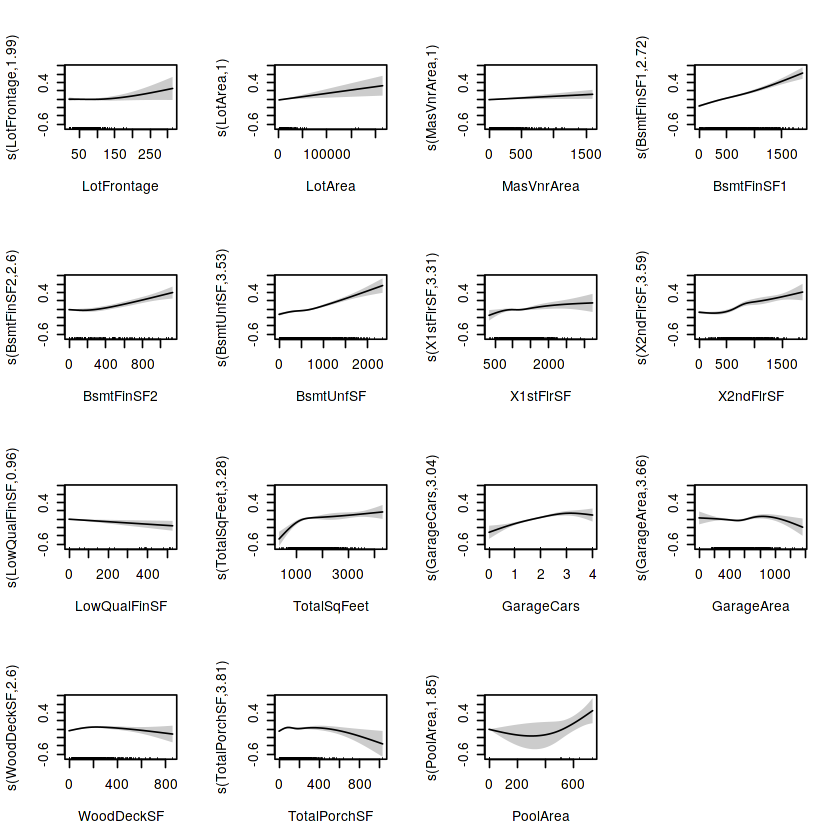

In [96]:
plot(modelGamNL,  pages = 1, scheme = 1, all.terms = TRUE, seWithMean = TRUE)
#options(repr.plot.width = 30, repr.plot.height = 40)
#plt.savefig("file_name.png")

### Modèle pour toutes les colonnes

In [97]:
fmQual <- paste(colQual, sep = "", collapse = ' + ')
fmQuant <- paste('s(', colQuant, ', k=5, bs="cr")', sep = "", collapse = ' + ')
fm <- paste(fmQual,'+',fmQuant)
fm <- as.formula(paste('SalePrice ~', fm))
fm

SalePrice ~ MSSubClass + Street + Alley + Utilities + Condition1 + 
    Condition2 + HouseStyle + OverallQual + OverallCond + RoofStyle + 
    RoofMatl + Exterior1st + Exterior2nd + AgeBuilt + AgeRemodAdd + 
    ExterQual + ExterCond + BsmtQual + BsmtCond + BsmtExposure + 
    BsmtFinType1 + BsmtFinType2 + Heating + HeatingQC + CentralAir + 
    BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + 
    KitchenAbvGr + KitchenQual + TotRmsAbvGrd + Fireplaces + 
    FireplaceQu + GarageAge + GarageFinish + GarageQual + GarageCond + 
    MiscFeaturePres + MoSold + YrSold + MSZoning.C..all. + MSZoning.FV + 
    MSZoning.RH + MSZoning.RL + MSZoning.RM + LotShape.IR1 + 
    LotShape.IR2 + LotShape.IR3 + LotShape.Reg + LandContour.Bnk + 
    LandContour.HLS + LandContour.Low + LandContour.Lvl + LotConfig.Corner + 
    LotConfig.CulDSac + LotConfig.FR2 + LotConfig.FR3 + LotConfig.Inside + 
    LandSlope.Gtl + LandSlope.Mod + LandSlope.Sev + Neighborhood.BlmCCC + 
    Neighborhood.

### GAM sur toutes les colonnes

In [98]:
modelGam <- gam(fm, data = dataAppLogGam)

In [99]:
summary(modelGam)


Family: gaussian 
Link function: identity 

Formula:
SalePrice ~ MSSubClass + Street + Alley + Utilities + Condition1 + 
    Condition2 + HouseStyle + OverallQual + OverallCond + RoofStyle + 
    RoofMatl + Exterior1st + Exterior2nd + AgeBuilt + AgeRemodAdd + 
    ExterQual + ExterCond + BsmtQual + BsmtCond + BsmtExposure + 
    BsmtFinType1 + BsmtFinType2 + Heating + HeatingQC + CentralAir + 
    BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + 
    KitchenAbvGr + KitchenQual + TotRmsAbvGrd + Fireplaces + 
    FireplaceQu + GarageAge + GarageFinish + GarageQual + GarageCond + 
    MiscFeaturePres + MoSold + YrSold + MSZoning.C..all. + MSZoning.FV + 
    MSZoning.RH + MSZoning.RL + MSZoning.RM + LotShape.IR1 + 
    LotShape.IR2 + LotShape.IR3 + LotShape.Reg + LandContour.Bnk + 
    LandContour.HLS + LandContour.Low + LandContour.Lvl + LotConfig.Corner + 
    LotConfig.CulDSac + LotConfig.FR2 + LotConfig.FR3 + LotConfig.Inside + 
    LandSlope.Gtl + LandSlope.Mod + La

In [100]:
# Make predictions
predictionsApp <- modelGam %>% predict(dataAppLogGam)
predictGamApp <- exp(predictionsApp)

data.frame(
  Rsquared = R.squared(predictGamApp, exp(dataAppLogGam$SalePrice)),
    
  Rsquared.adj = R.squared.adj(predictGamApp, exp(dataAppLogGam$SalePrice),
                             nrow(dataAppLogGam), ncol(dataAppLogGam[, -1])),
    
  RMSE = RMSE(predictGamApp, exp(dataAppLogGam$SalePrice)),
  RMSLE = rmsle(predictGamApp, exp(dataAppLogGam$SalePrice))
)

Rsquared,Rsquared.adj,RMSE,RMSLE
<dbl>,<dbl>,<dbl>,<dbl>
0.9537264,0.9463564,16163.18,0.09061758


In [101]:
Perfopm10(exp(dataAppLog$SalePrice), predictGamApp)

 
********************** 
 Erreurs  en prevision  
********************** 
 
 R²      =  0.9781  
 RMSE   =  16163.18  
 RMSLE   =  0.0906  
  


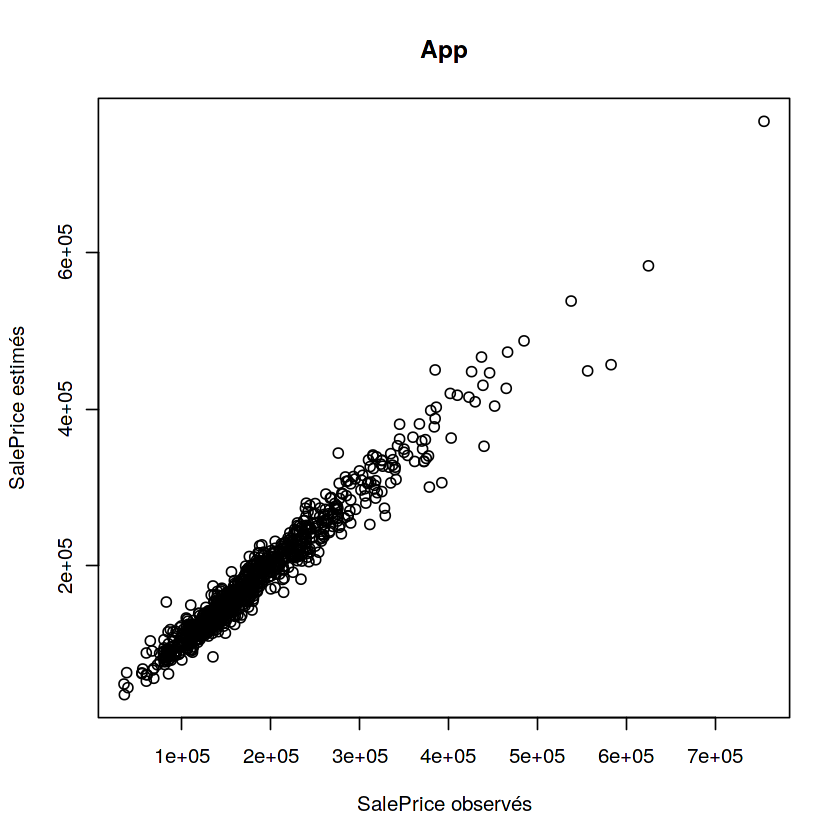

In [102]:
plot(exp(dataAppLogGam$SalePrice),predictGamApp,  main="App", xlab="SalePrice observés", 
     ylab="SalePrice estimés")
abline(h=0,col="red")

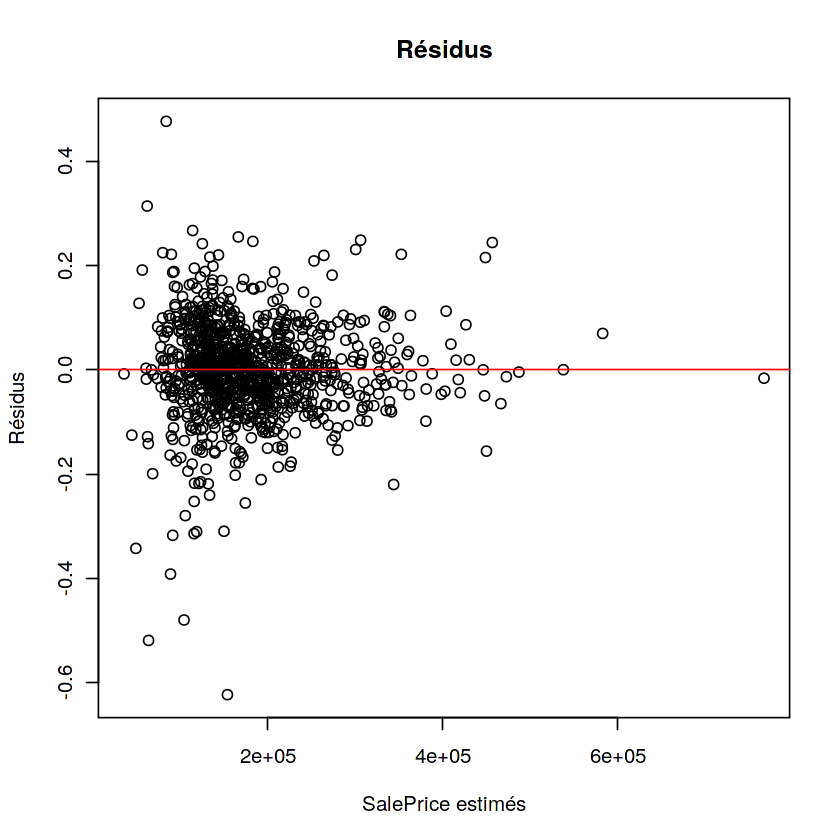

In [103]:
residus <- modelGam$residuals
plot(predictGamApp,residus,  main="Résidus", xlab="SalePrice estimés", ylab="Résidus")
abline(h=0,col="red")

In [104]:
# Make predictions
predictionsTest <- modelGam %>% predict(dataTestLogGam)
predictGamTest <- exp(predictionsTest)

data.frame(
  Rsquared = R.squared(predictGamTest, exp(dataTestLogGam$SalePrice)),
    
  Rsquared.adj = R.squared.adj(predictGamTest, exp(dataTestLogGam$SalePrice),
                             nrow(dataTestLogGam), ncol(dataTestLogGam[, -1])),
    
  RMSE = RMSE(predictGamTest, exp(dataTestLogGam$SalePrice)),
  RMSLE = rmsle(predictGamTest, exp(dataTestLogGam$SalePrice))
)

Rsquared,Rsquared.adj,RMSE,RMSLE
<dbl>,<dbl>,<dbl>,<dbl>
0.9043067,0.8591987,24144.31,0.182354


In [105]:
Perfopm10(exp(dataTestLog$SalePrice), predictGamTest)

 
********************** 
 Erreurs  en prevision  
********************** 
 
 R²      =  0.9579  
 RMSE   =  24144.31  
 RMSLE   =  0.1824  
  


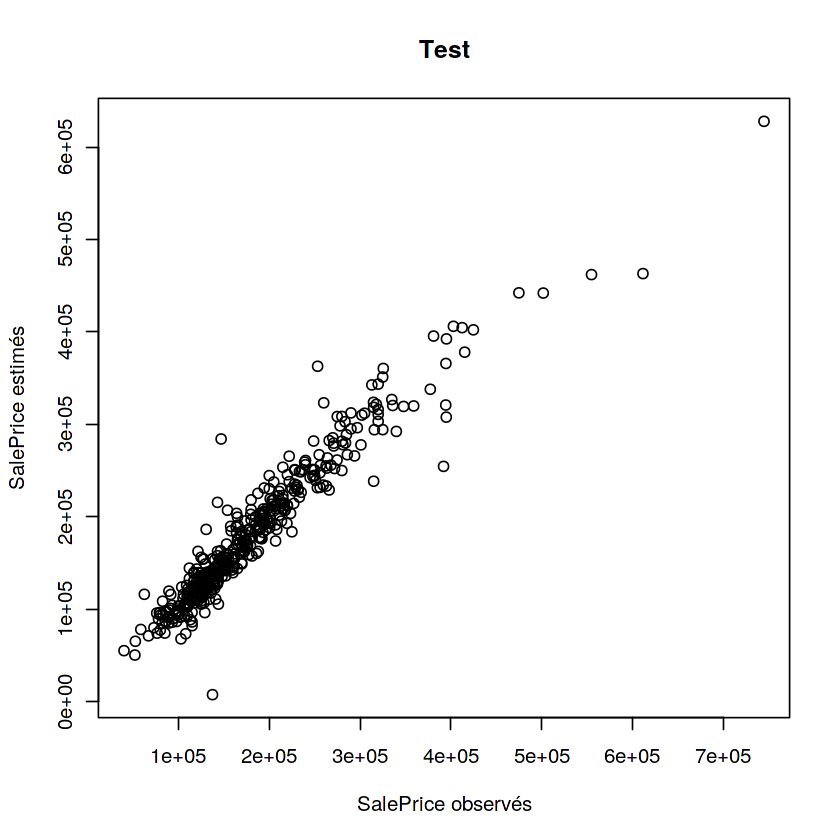

In [106]:
plot(exp(dataTestLogGam$SalePrice), predictGamTest, main="Test", xlab="SalePrice observés", 
     ylab="SalePrice estimés")


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 17 iterations.
The RMS GCV score gradient at convergence was 7.328222e-09 .
The Hessian was positive definite.
Model rank =  166 / 186 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                   k'   edf k-index p-value   
s(LotFrontage)  4.000 1.000    1.04   0.890   
s(LotArea)      4.000 3.817    0.97   0.210   
s(MasVnrArea)   4.000 1.000    1.07   0.990   
s(BsmtFinSF1)   4.000 3.775    1.03   0.820   
s(BsmtFinSF2)   4.000 1.555    1.02   0.755   
s(BsmtUnfSF)    4.000 2.098    0.99   0.330   
s(X1stFlrSF)    4.000 3.630    0.97   0.150   
s(X2ndFlrSF)    4.000 0.829    1.01   0.620   
s(LowQualFinSF) 4.000 2.446    1.01   0.600   
s(TotalSqFeet)  4.000 2.780    0.90   0.005 **
s(GarageCars)   4.000 1.000    1.04   0.940   
s(GarageArea)   4.000 2.746    1.04   0.930   
s(WoodDeckSF)   4.000 1.000    0.96   0.080 .

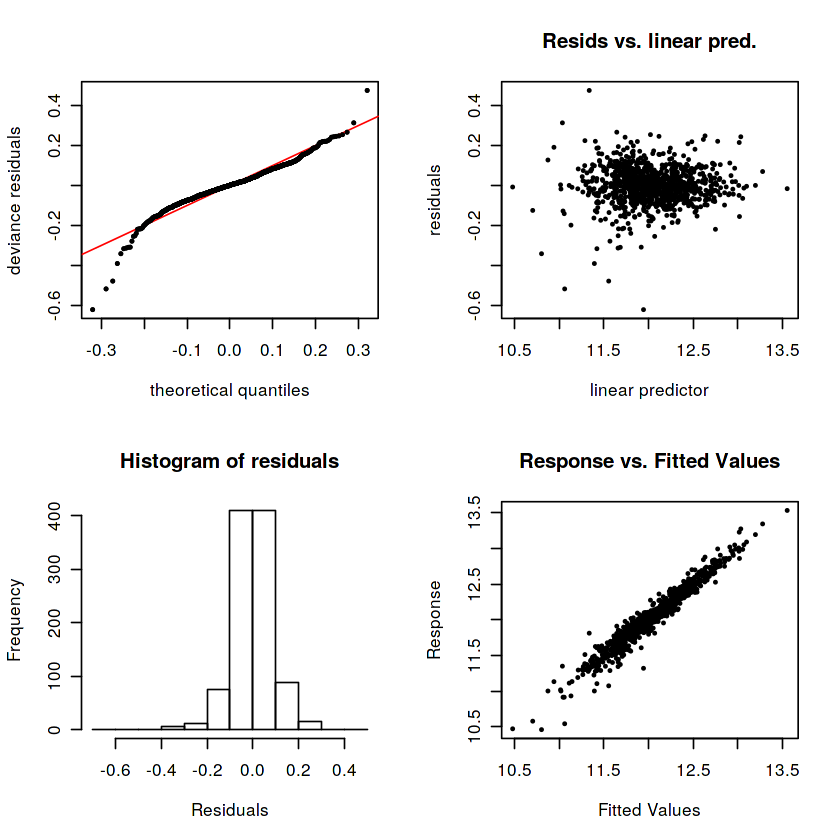

In [107]:
#options(repr.plot.width = 7, repr.plot.height = 7)
gam.check(modelGam,pch=19,cex=.3)

In [108]:
#plot(modelGam, all.terms = TRUE, seWithMean = TRUE)

In [109]:
#plot(modelGam)

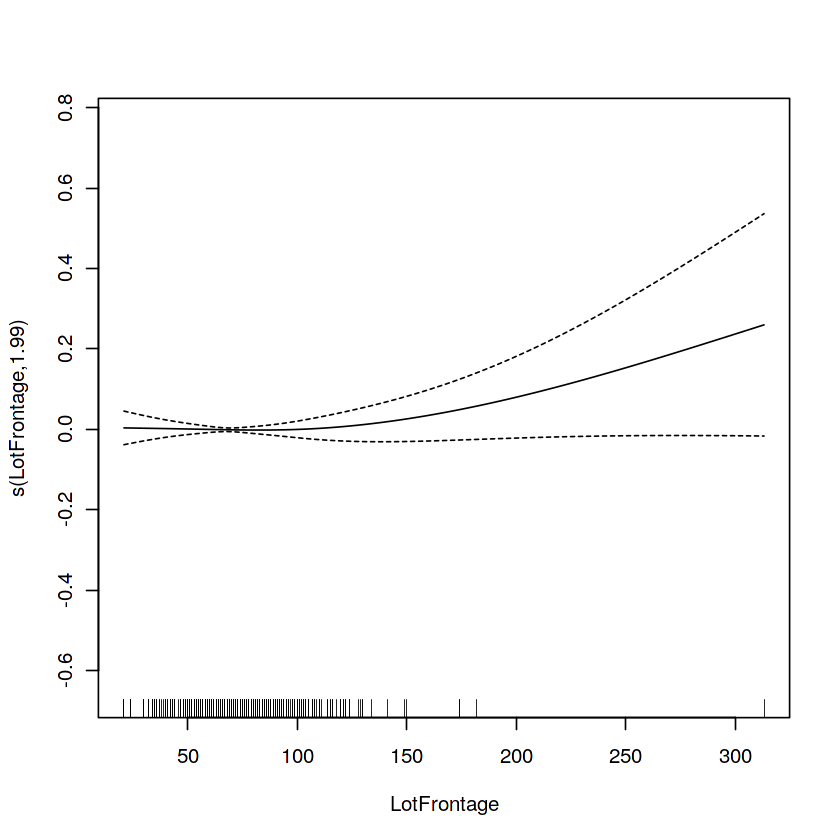

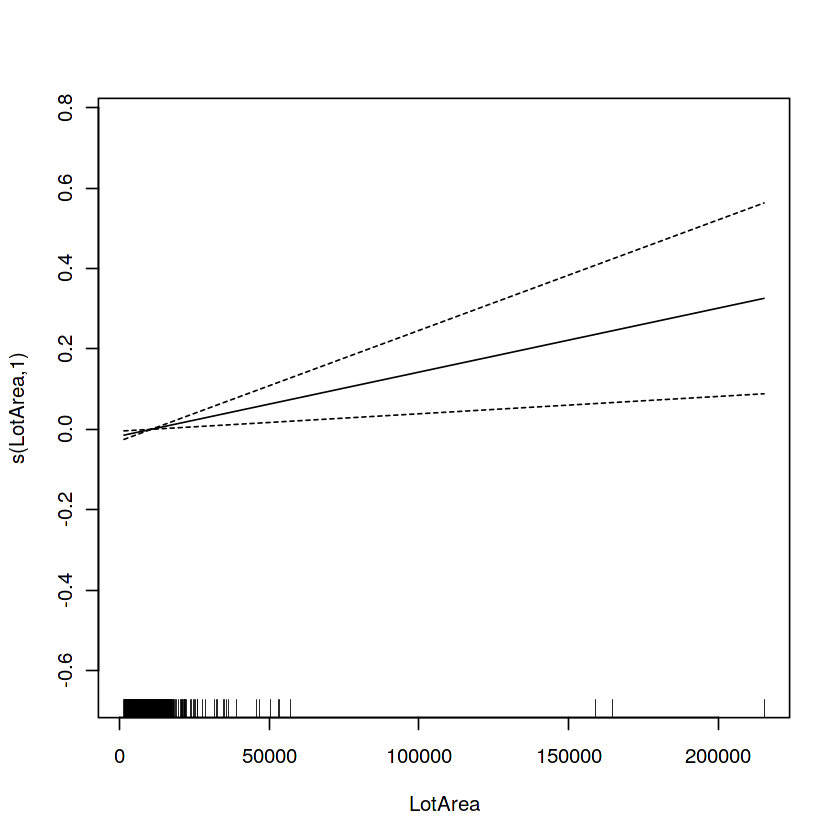

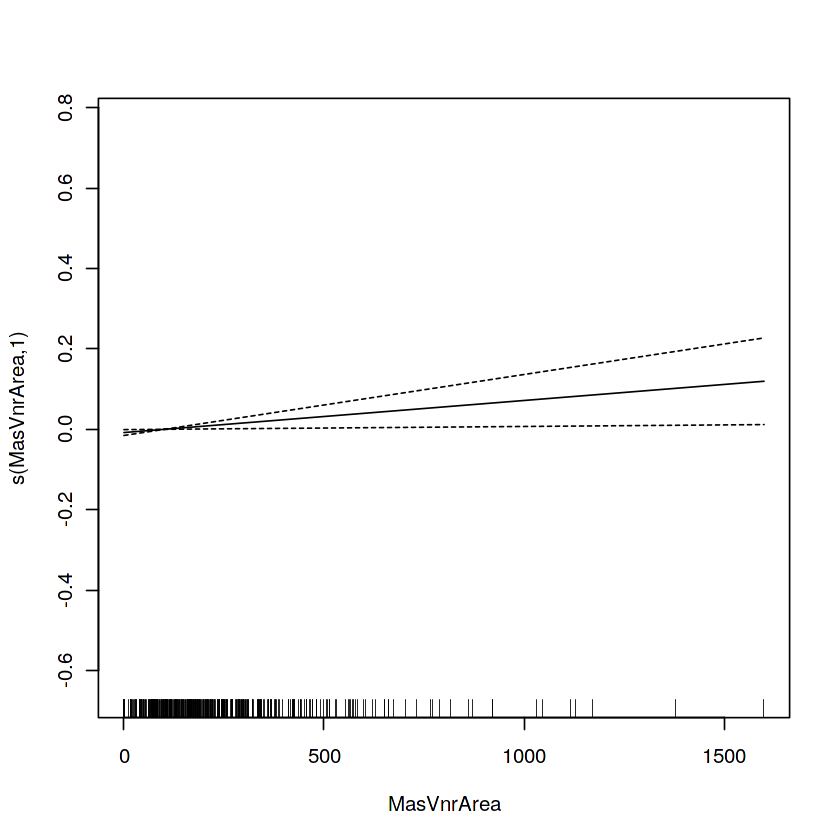

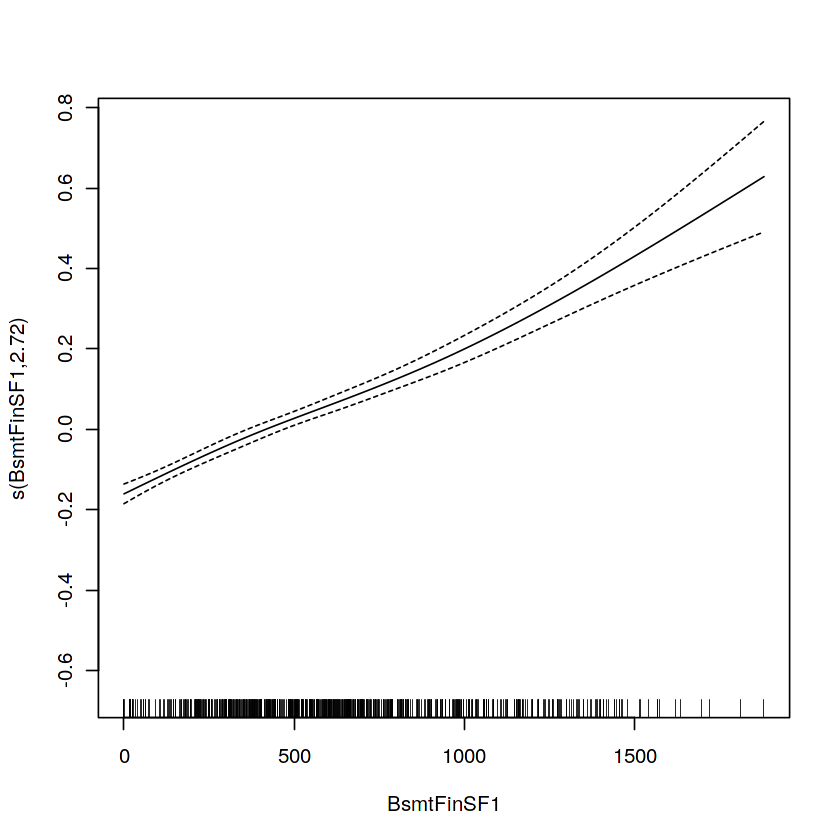

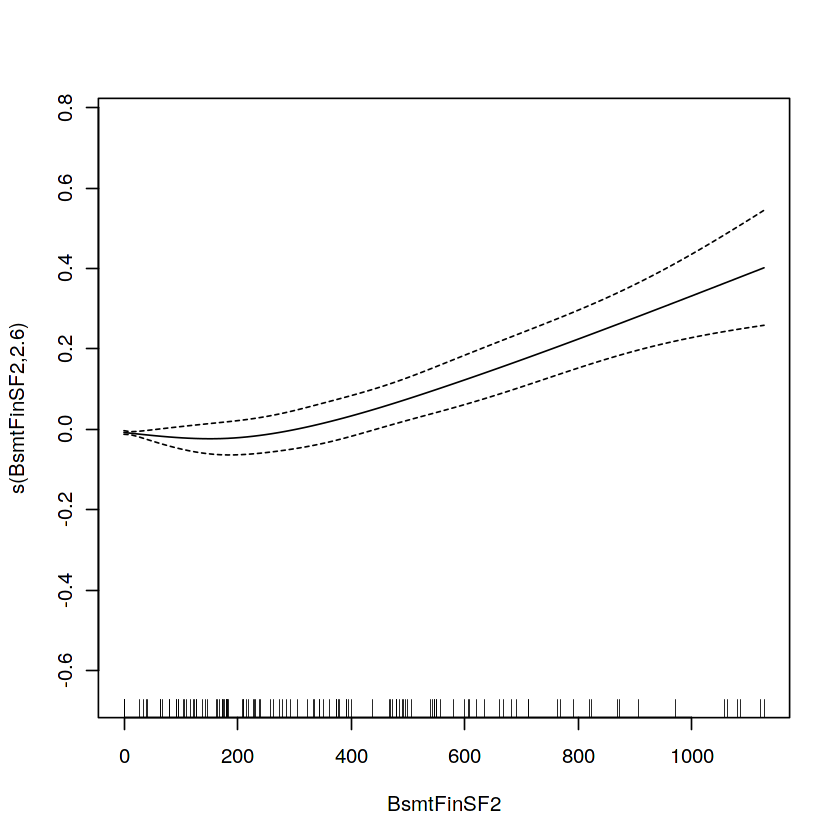

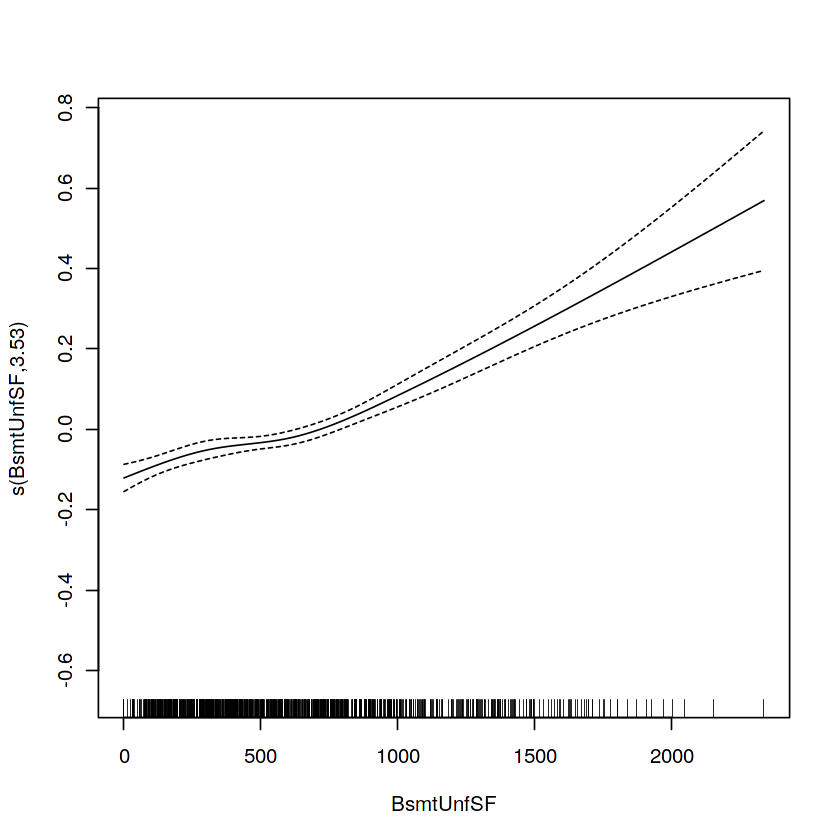

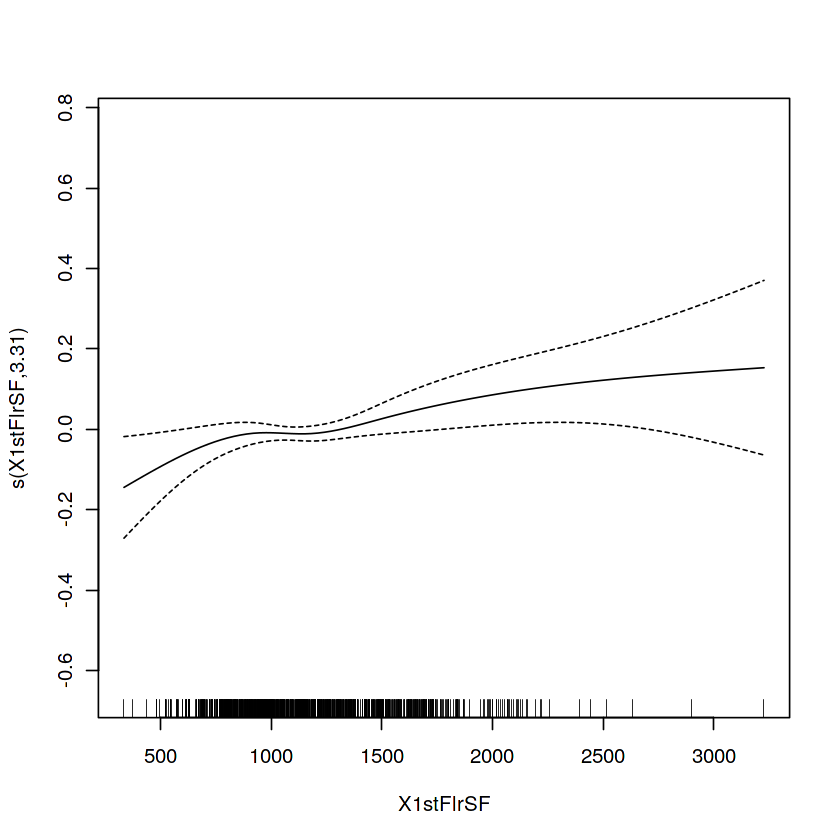

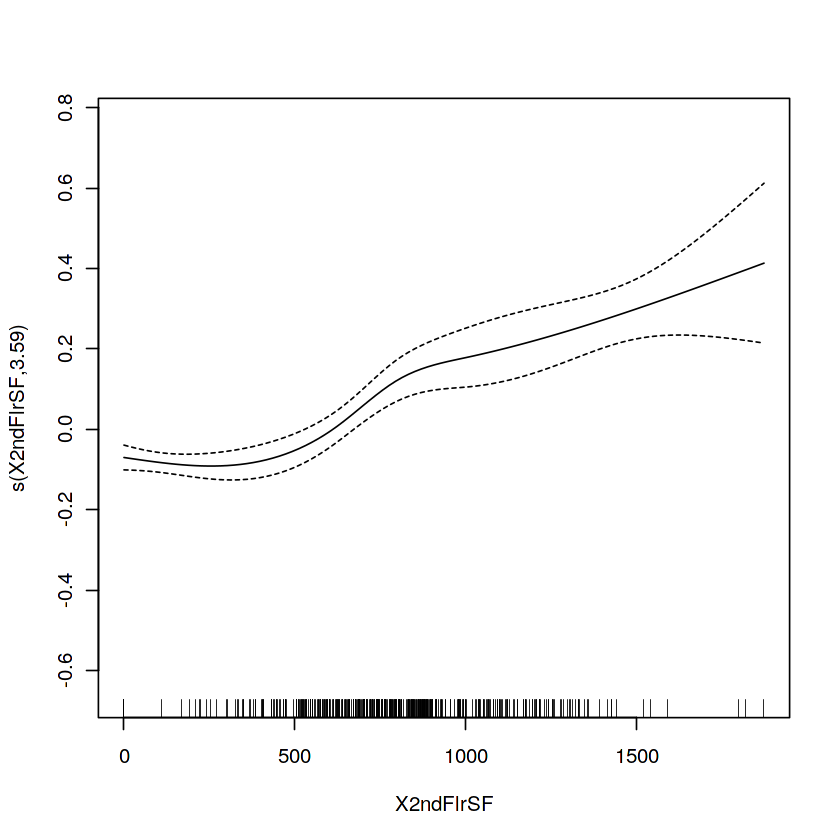

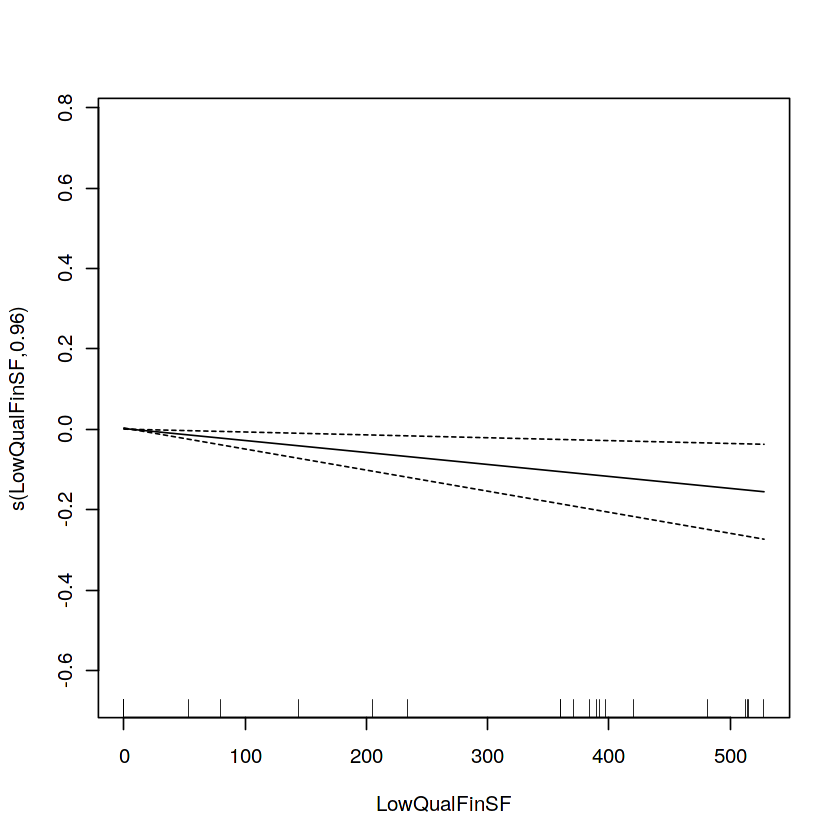

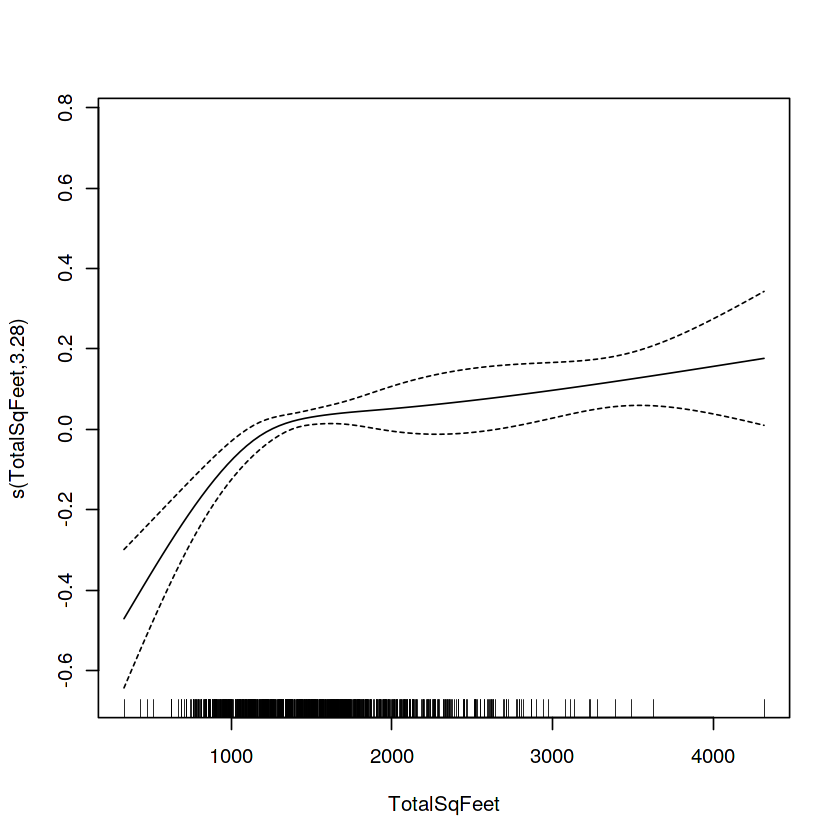

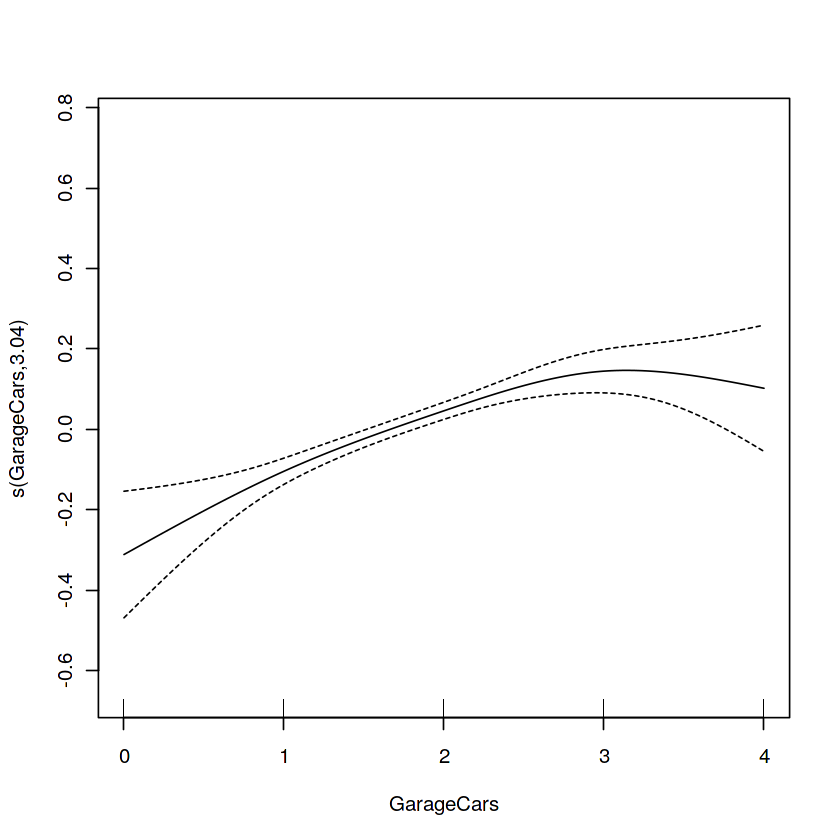

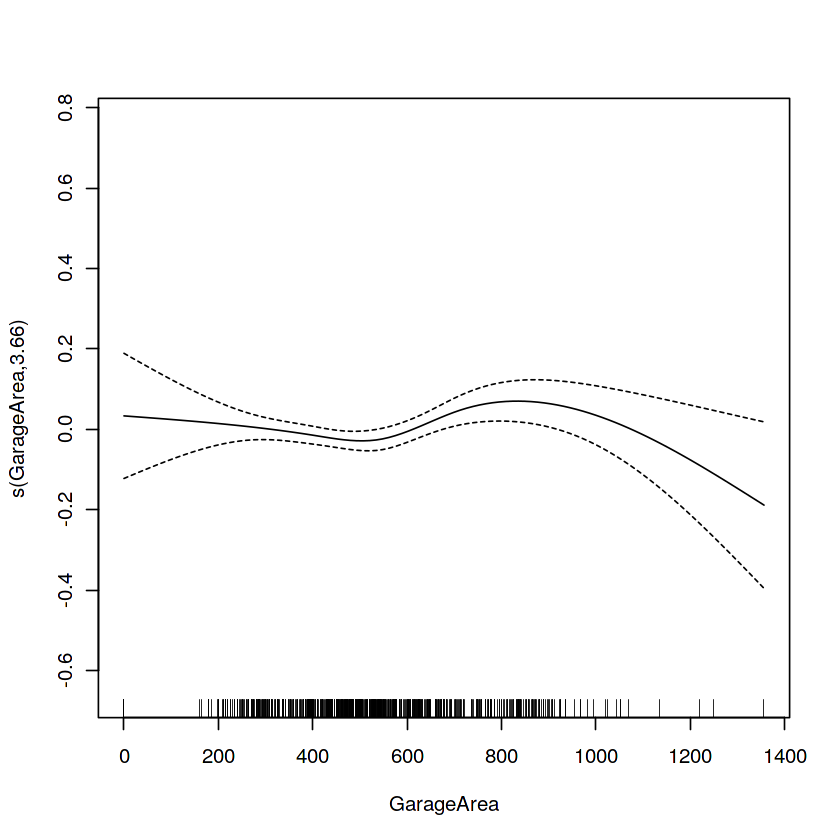

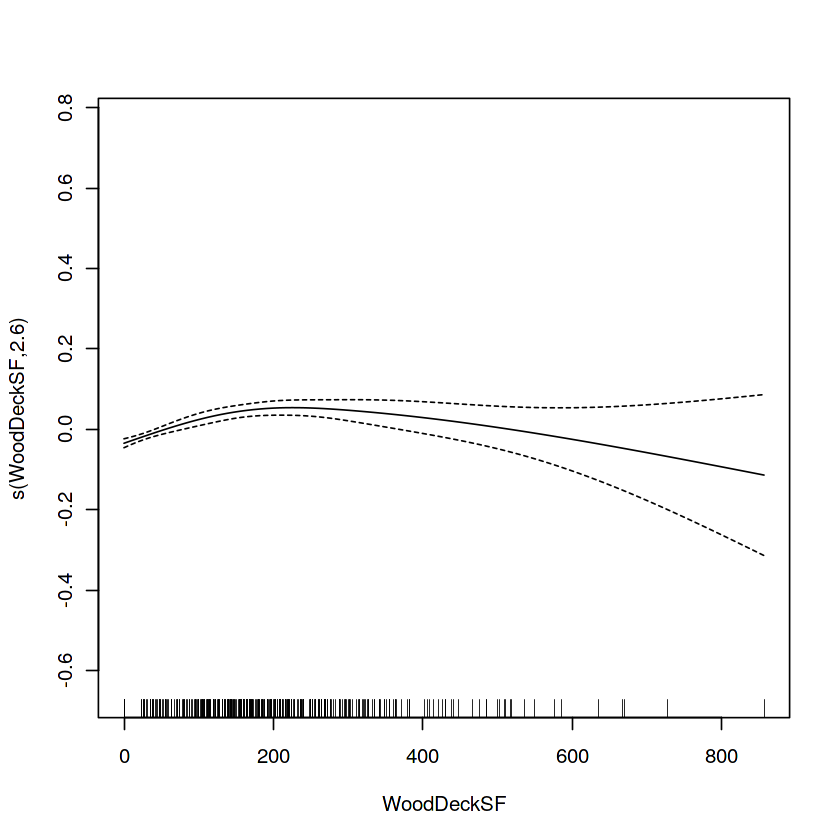

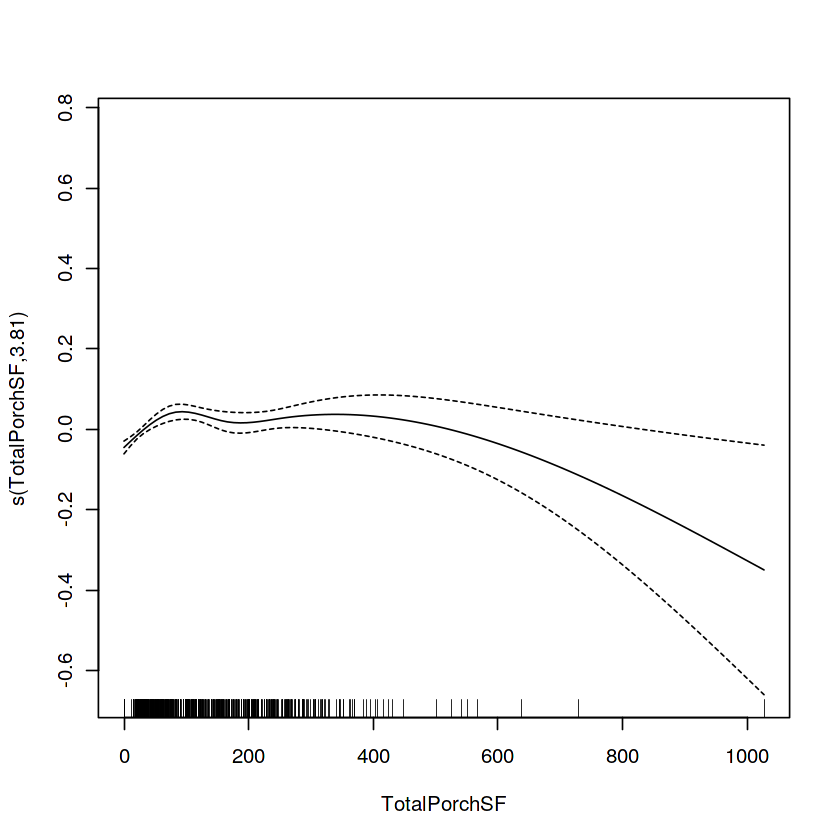

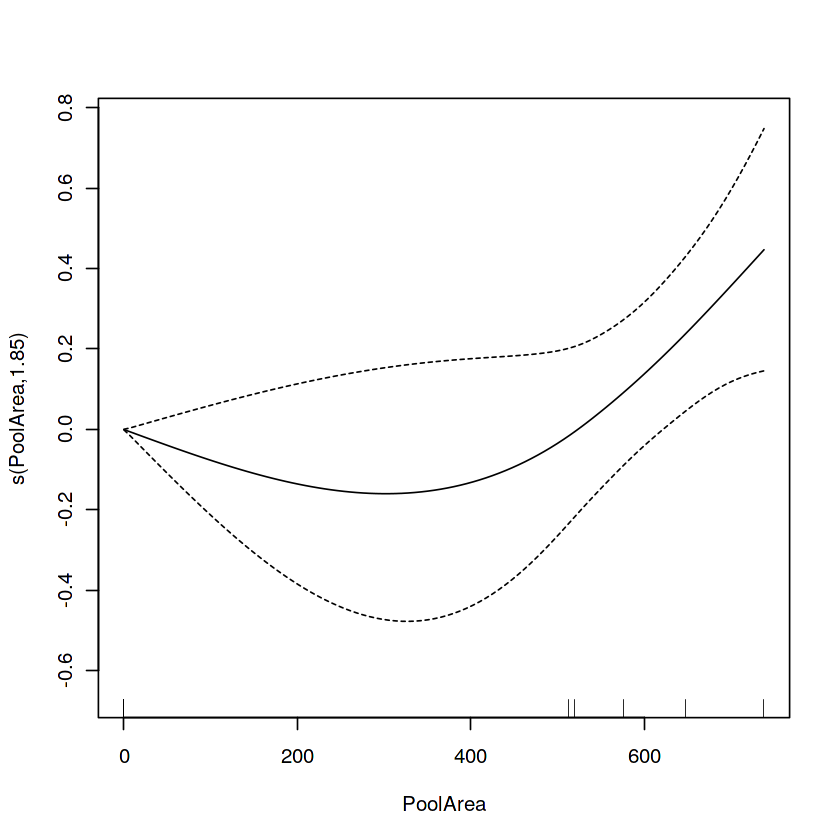

In [110]:
plot(modelGamNL)

colQuant[-length(colQuant)]

fmQuant <- paste(colQuant, sep = "", collapse = ' + ')
fmQuantNL1 <- paste('s(', colQuant[-length(colQuant)], ', k=5, bs="cr")', sep = "", collapse = ' + ')
fmNL1 <- paste(fmQuant,'+',fmQuantNL1,'+s(PoolArea, k=6, bs="cr")')
fmNL1 <- as.formula(paste('SalePrice ~', fmNL1))
fmNL1

modelGamNL1 <- gam(fmNL1, data = dataAppLogGam)
summary(modelGamNL)

plot(modelGamNL1)